<img src="https://i.imgur.com/RGQekkH.png" alt="alt text" width="300" height="300">


**Authored by Shashank Raj using Gemini AI ✨.**

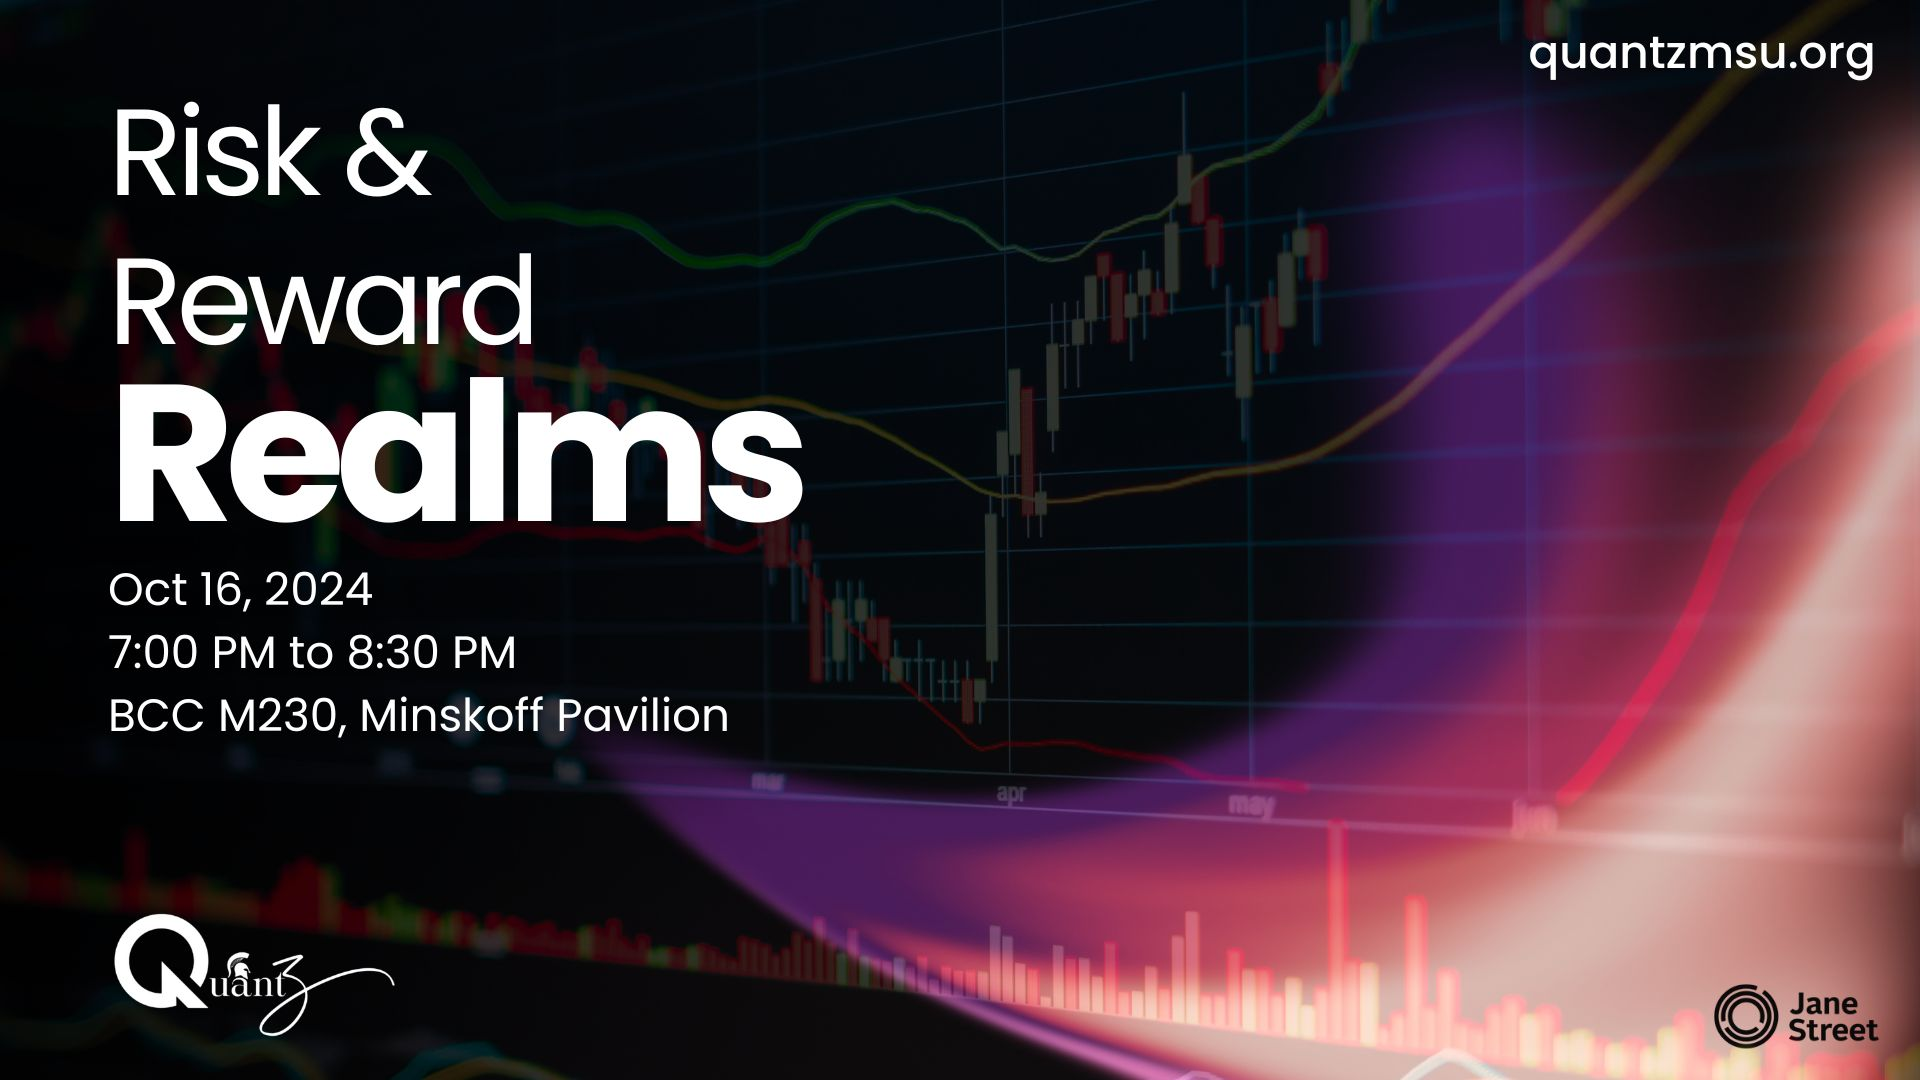

In [5]:
# @title Volatility Ventures 🌪️📊  {"display-mode":"form"}
!pip install -q ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install -q plotly
!pip install -q scipy

!jupyter nbextension enable --py widgetsnbextension --sys-prefix --quiet
# Import necessary packages
import numpy as np
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import plotly.graph_objects as go
import plotly.express as px
import random
import datetime
import json
import os
from scipy.stats import norm

# Apply Plotly default theme
import plotly.io as pio
pio.templates.default = "plotly_dark"

# Define the main game function
def volatility_ventures_advanced():
    # ============================
    # ==== GAME PARAMETERS =======
    # ============================
    INITIAL_CAPITAL = 100000  # Starting capital in $
    NUM_ROUNDS = 20  # Total number of rounds
    ASSET_CLASSES = {
        'Equities': {'initial_price': 100, 'drift': 0.0005, 'volatility': 0.02},
        'Bonds': {'initial_price': 100, 'drift': 0.0002, 'volatility': 0.005},
        'Commodities': {'initial_price': 100, 'drift': 0.0003, 'volatility': 0.01},
        'Cryptocurrencies': {'initial_price': 100, 'drift': 0.001, 'volatility': 0.03}
    }

    RISK_FREE_RATE = 0.0002  # Approximate daily risk-free rate

    # Risk Metrics Targets
    SHARPE_RATIO_TARGET = 1.5
    VAR_TARGET = 0.05  # Value at Risk at 5% confidence level
    MAX_DRAWDOWN_LIMIT = 0.2  # Maximum Drawdown Limit at 20%

    # ============================
    # ==== INITIALIZE GAME STATE ==
    # ============================
    capital = INITIAL_CAPITAL
    capital_history = [capital]
    asset_prices = {asset: data['initial_price'] for asset, data in ASSET_CLASSES.items()}
    asset_history = {asset: [price] for asset, price in asset_prices.items()}
    score = 0
    penalties = 0
    current_round = 1
    max_drawdown = 0
    portfolio = {asset: 0 for asset in ASSET_CLASSES.keys()}
    portfolio_history = []
    portfolio_value_history = [capital]
    sharpe_history = []
    var_history = []
    drawdown_history = []

    # List of assets for indexing
    assets = list(ASSET_CLASSES.keys())

    # Correlation matrix for assets
    correlation_matrix = np.array([
        [1.0, 0.2, 0.3, 0.1],
        [0.2, 1.0, 0.1, 0.05],
        [0.3, 0.1, 1.0, 0.2],
        [0.1, 0.05, 0.2, 1.0]
    ])
    # Construct covariance matrix
    volatilities = [ASSET_CLASSES[asset]['volatility'] for asset in assets]
    covariance_matrix = np.outer(volatilities, volatilities) * correlation_matrix

    # Generate Market Conditions and Economic Indicators for Each Round
    market_conditions = []
    economic_indicators = []
    for _ in range(NUM_ROUNDS):
        condition = random.choices(
            ['Bull Market', 'Bear Market', 'Sideways Market', 'Volatile Market', 'Extreme Volatility'],
            weights=[20, 20, 30, 20, 10],
            k=1
        )[0]
        market_conditions.append(condition)

        # Simulate economic indicators as news events
        news_event = random.choices(
            ['Stable Economy', 'Economic Growth', 'Recession Fears', 'Technological Breakthrough', 'Geopolitical Tensions'],
            weights=[25, 25, 20, 15, 15],
            k=1
        )[0]
        economic_indicators.append(news_event)

    # ============================
    # ======= DEFINE WIDGETS =====
    # ============================

    # Intro Screen Widgets
    intro_label = widgets.HTML(value=f"""
        <h1 style="text-align:center;">🌪️ Volatility Ventures 3.0 📊</h1>
        <p style="font-size:16px;">
            Welcome to <b>Volatility Ventures 3.0</b>! This is the most advanced trading simulation game where you can manage a diversified portfolio across multiple asset classes in a dynamic and volatile market environment.
        </p>
        <p><b>Initial Capital:</b> ${INITIAL_CAPITAL:,}</p>
        <p><b>Total Rounds:</b> {NUM_ROUNDS}</p>
        <p>Click <b>"Start Game"</b> to begin your investment journey!</p>
    """, layout=widgets.Layout(width='80%', margin='auto'))

    start_button = widgets.Button(
        description='Start Game',
        button_style='success',
        tooltip='Click to start the game',
        layout=widgets.Layout(width='150px', height='50px')
    )

    # Game UI Widgets
    progress_label = widgets.HTML(value=f"Round: {current_round} / {NUM_ROUNDS}")
    score_label = widgets.HTML(value=f"Score: {score} | Penalties: {penalties}")
    capital_label = widgets.HTML(value=f"Capital: ${capital:,.2f}")

    # Portfolio Allocation Sliders
    allocation_sliders = {}
    for asset in ASSET_CLASSES.keys():
        allocation_sliders[asset] = widgets.FloatSlider(
            value=0.0,
            min=0.0,
            max=1.0,
            step=0.05,
            description=f"{asset}:",
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='90%')
        )
        allocation_sliders[asset].tooltip = f"Allocate a portion of your capital to {asset}"

    allocation_total = widgets.HTML(value="<b>Total Allocation:</b> 0.0%")

    # Function to update total allocation
    def update_total_allocation(change):
        total = sum([slider.value for slider in allocation_sliders.values()])
        allocation_total.value = f"<b>Total Allocation:</b> {total*100:.1f}%"
        if total > 1.0:
            allocation_total.add_class("red-text")
        else:
            allocation_total.remove_class("red-text")

    for slider in allocation_sliders.values():
        slider.observe(update_total_allocation, names='value')

    # Proceed Button
    proceed_button = widgets.Button(
        description='Execute Strategy & Proceed',
        button_style='info',
        disabled=True,
        tooltip='Click to execute your strategy and proceed to the next round',
        layout=widgets.Layout(width='250px', height='50px')
    )

    # Enable proceed button only if total allocation is <=100% and >0%
    def check_allocation(change):
        total = sum([slider.value for slider in allocation_sliders.values()])
        proceed_button.disabled = (total > 1.0 or total == 0.0)

    for slider in allocation_sliders.values():
        slider.observe(check_allocation, names='value')

    # Output Areas
    output_area = widgets.Output()
    graph_area = widgets.Output()
    metrics_graph_area = widgets.Output()

    # Save and Load Buttons
    save_button = widgets.Button(
        description='Save Game',
        button_style='warning',
        tooltip='Save your current game state',
        layout=widgets.Layout(width='120px', height='40px')
    )

    load_button = widgets.Button(
        description='Load Game',
        button_style='primary',
        tooltip='Load a previously saved game state',
        layout=widgets.Layout(width='120px', height='40px')
    )

    # Display Widgets Container
    game_ui_container = widgets.VBox([
        widgets.HBox([progress_label, score_label, capital_label]),
        widgets.Label("Allocate your capital across different asset classes:"),
        *[allocation_sliders[asset] for asset in ASSET_CLASSES.keys()],
        allocation_total,
        proceed_button,
        widgets.HBox([save_button, load_button]),
        widgets.HBox([output_area, graph_area]),
        metrics_graph_area
    ], layout=widgets.Layout(align_items='flex-start'))

    # ============================
    # ====== DEFINE FUNCTIONS =====
    # ============================

    # Function to simulate market movement for each asset using Geometric Brownian Motion
    def simulate_market_movement(round_num):
        condition = market_conditions[round_num - 1]
        indicator = economic_indicators[round_num - 1]
        impact_factors = {
            'Bull Market': 1.05,
            'Bear Market': 0.95,
            'Sideways Market': 1.00,
            'Volatile Market': 1.10,
            'Extreme Volatility': 1.20
        }
        indicator_effect = {
            'Stable Economy': 0.0,
            'Economic Growth': 0.02,
            'Recession Fears': -0.02,
            'Technological Breakthrough': 0.015,
            'Geopolitical Tensions': -0.015
        }
        market_factor = impact_factors.get(condition, 1.0)
        indicator_factor = indicator_effect.get(indicator, 0.0)

        # Adjust drift based on market condition and economic indicators
        adjusted_drift = {}
        for asset in assets:
            adjusted_drift[asset] = ASSET_CLASSES[asset]['drift'] * market_factor + indicator_factor

        # Simulate price changes using GBM with multivariate normal distribution
        mean_returns = np.array([adjusted_drift[asset] for asset in assets])
        price_changes = np.random.multivariate_normal(mean_returns, covariance_matrix)

        for i, asset in enumerate(assets):
            asset_prices[asset] *= np.exp(price_changes[i])
            asset_prices[asset] = max(asset_prices[asset], 1)  # Prevent negative or zero prices
            asset_prices[asset] = round(asset_prices[asset], 2)
            asset_history[asset].append(asset_prices[asset])

    # Function to calculate portfolio return and risk metrics
    def calculate_portfolio_metrics(allocation, round_num):
        # Calculate portfolio weights
        weights = np.array([allocation[asset] for asset in assets])

        # Calculate portfolio return based on asset returns
        asset_returns = np.array([
            (asset_prices[asset] / asset_history[asset][-2]) - 1 for asset in assets
        ])
        portfolio_return = np.dot(weights, asset_returns)

        # Calculate portfolio variance using covariance matrix
        portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix, weights))
        portfolio_std = np.sqrt(portfolio_variance)

        # Calculate Sharpe Ratio
        sharpe_ratio = (portfolio_return - RISK_FREE_RATE) / portfolio_std if portfolio_std != 0 else 0

        # Calculate Parametric VaR at 95% confidence
        var = norm.ppf(0.95, portfolio_return, portfolio_std)
        var = abs(var)  # VaR is typically expressed as a positive number

        return portfolio_return, sharpe_ratio, var

    # Function to calculate maximum drawdown
    def calculate_max_drawdown():
        peak = max(capital_history)
        current_drawdown = (peak - capital) / peak if peak != 0 else 0
        return current_drawdown

    # Function to create risk metrics plots
    def make_metrics_plots():
        fig = go.Figure()

        # Sharpe Ratio over time
        if sharpe_history:
            fig.add_trace(go.Scatter(
                x=list(range(1, len(sharpe_history)+1)),
                y=sharpe_history,
                mode='lines+markers',
                name='Sharpe Ratio',
                yaxis='y1'
            ))

        # VaR over time
        if var_history:
            fig.add_trace(go.Scatter(
                x=list(range(1, len(var_history)+1)),
                y=var_history,
                mode='lines+markers',
                name='Value at Risk (VaR)',
                yaxis='y2'
            ))

        # Maximum Drawdown over time
        if drawdown_history:
            fig.add_trace(go.Scatter(
                x=list(range(1, len(drawdown_history)+1)),
                y=drawdown_history,
                mode='lines+markers',
                name='Maximum Drawdown',
                yaxis='y3'
            ))

        # Layout
        fig.update_layout(
            title='Risk Metrics Over Time',
            xaxis=dict(title='Round'),
            yaxis=dict(
                title='Sharpe Ratio',
                titlefont=dict(color='blue'),
                tickfont=dict(color='blue')
            ),
            yaxis2=dict(
                title='VaR',
                overlaying='y',
                side='right',
                titlefont=dict(color='orange'),
                tickfont=dict(color='orange')
            ),
            yaxis3=dict(
                title='Max Drawdown',
                overlaying='y',
                side='right',
                anchor='free',
                position=1.0,
                titlefont=dict(color='green'),
                tickfont=dict(color='green')
            ),
            legend=dict(x=0, y=1.2, orientation='h'),
            template='plotly_dark',
            margin=dict(l=50, r=50, t=100, b=50)
        )

        return fig

    # Function to handle proceed button click
    def proceed_round(b):
        nonlocal current_round, score, penalties, capital, portfolio

        # Gather allocation inputs
        allocation = {asset: allocation_sliders[asset].value for asset in ASSET_CLASSES.keys()}

        # Normalize allocations if total <1.0 by keeping cash
        total_alloc = sum(allocation.values())
        cash = 1.0 - total_alloc
        if cash < 0:
            with output_area:
                clear_output()
                print("<span style='color:red;'>Total allocation exceeds 100%. Please adjust your allocations.</span>")
            return

        # Simulate market movement
        simulate_market_movement(current_round)

        # Calculate portfolio metrics
        portfolio_return, sharpe_ratio, var = calculate_portfolio_metrics(allocation, current_round)

        # Update capital based on portfolio return
        portfolio_value = capital * (1 + portfolio_return)
        portfolio_history.append(allocation.copy())
        portfolio_value_history.append(round(portfolio_value, 2))
        capital = round(portfolio_value, 2)
        capital_history.append(capital)

        # Record risk metrics
        sharpe_history.append(sharpe_ratio)
        var_history.append(var)

        # Calculate maximum drawdown
        max_drawdown = calculate_max_drawdown()
        drawdown_history.append(max_drawdown)

        # Update score and penalties based on risk metrics
        round_score = 0
        round_penalties = 0

        if sharpe_ratio >= SHARPE_RATIO_TARGET:
            round_score += 20
        else:
            round_penalties += 10

        if var > VAR_TARGET:
            round_penalties += 15

        if max_drawdown > MAX_DRAWDOWN_LIMIT:
            round_penalties += 20

        score += round_score
        penalties += round_penalties

        # Update capital label
        capital_label.value = f"Capital: ${capital:,.2f}"
        score_label.value = f"Score: {score} | Penalties: {penalties}"

        # Update asset history
        with graph_area:
            clear_output(wait=True)
            fig = go.Figure()
            for asset in ASSET_CLASSES.keys():
                fig.add_trace(go.Scatter(
                    x=list(range(1, current_round + 2)),
                    y=asset_history[asset],
                    mode='lines+markers',
                    name=asset
                ))
            fig.update_layout(
                title='Asset Price History',
                xaxis_title='Round',
                yaxis_title='Price ($)',
                legend_title='Assets',
                template='plotly_dark',
                margin=dict(l=50, r=50, t=50, b=50)
            )
            fig.show()

        # Update risk metrics graphs
        with metrics_graph_area:
            clear_output(wait=True)
            fig_metrics = make_metrics_plots()
            fig_metrics.show()

        # Display round results
        with output_area:
            clear_output()
            display(HTML(f"""
                <h3>Round {current_round} Summary</h3>
                <p><b>Market Condition:</b> {market_conditions[current_round - 1]}</p>
                <p><b>Economic Indicator:</b> {economic_indicators[current_round - 1]}</p>
                <p><b>Portfolio Allocation:</b> {', '.join([f"{asset}: {allocation[asset]*100:.1f}%" for asset in ASSET_CLASSES.keys()])} | Cash: {cash*100:.1f}%</p>
                <p><b>Portfolio Return:</b> {portfolio_return*100:.2f}%</p>
                <p><b>Sharpe Ratio:</b> {sharpe_ratio:.2f}</p>
                <p><b>Value at Risk (VaR):</b> ${var*capital:,.2f}</p>
                <p><b>Maximum Drawdown:</b> {max_drawdown*100:.2f}%</p>
                <p><b>Round Score:</b> {round_score} | <b>Round Penalties:</b> {round_penalties}</p>
                <hr>
            """))

        # Increment round
        current_round += 1

        # Check for game end conditions
        if current_round > NUM_ROUNDS or capital <= 0:
            end_game()
        else:
            # Update progress label
            progress_label.value = f"Round: {current_round} / {NUM_ROUNDS}"
            # Reset allocation sliders
            for slider in allocation_sliders.values():
                slider.value = 0.0
            allocation_total.value = "<b>Total Allocation:</b> 0.0%"
            # Prompt next round
            with output_area:
                print(f"**Round {current_round} Begins!**")
                print(f"You have ${capital:,.2f} to invest.")
                print("Allocate your capital across the available asset classes and click 'Execute Strategy & Proceed'.")

    # Function to create risk metrics plots
    def make_metrics_plots():
        fig = go.Figure()

        # Sharpe Ratio over time
        if sharpe_history:
            fig.add_trace(go.Scatter(
                x=list(range(1, len(sharpe_history)+1)),
                y=sharpe_history,
                mode='lines+markers',
                name='Sharpe Ratio',
                yaxis='y1',
                line=dict(color='blue')
            ))

        # VaR over time
        if var_history:
            fig.add_trace(go.Scatter(
                x=list(range(1, len(var_history)+1)),
                y=var_history,
                mode='lines+markers',
                name='Value at Risk (VaR)',
                yaxis='y2',
                line=dict(color='orange')
            ))

        # Maximum Drawdown over time
        if drawdown_history:
            fig.add_trace(go.Scatter(
                x=list(range(1, len(drawdown_history)+1)),
                y=drawdown_history,
                mode='lines+markers',
                name='Maximum Drawdown',
                yaxis='y3',
                line=dict(color='green')
            ))

        # Layout
        fig.update_layout(
            title='Risk Metrics Over Time',
            xaxis=dict(title='Round'),
            yaxis=dict(
                title='Sharpe Ratio',
                titlefont=dict(color='blue'),
                tickfont=dict(color='blue')
            ),
            yaxis2=dict(
                title='VaR',
                overlaying='y',
                side='right',
                titlefont=dict(color='orange'),
                tickfont=dict(color='orange')
            ),
            yaxis3=dict(
                title='Max Drawdown',
                overlaying='y',
                side='right',
                anchor='free',
                position=1.0,
                titlefont=dict(color='green'),
                tickfont=dict(color='green')
            ),
            legend=dict(x=0, y=1.2, orientation='h'),
            template='plotly_dark',
            margin=dict(l=50, r=50, t=100, b=50)
        )

        return fig

    # Function to end the game
    def end_game():
        clear_output(wait=True)
        final_score = score - penalties
        final_label = widgets.HTML(value=f"""
            <h2 style="color:green;">🏁 Game Over! 🏁</h2>
            <p><b>Final Capital:</b> ${capital:,.2f}</p>
            <p><b>Total Score:</b> {score} | <b>Total Penalties:</b> {penalties}</p>
            <p><b>Net Score:</b> {final_score}</p>
            <h3>Thank you for playing Volatility Ventures 3.0!</h3>
        """)
        display(final_label)
        # Disable further interactions
        proceed_button.disabled = True
        for slider in allocation_sliders.values():
            slider.disabled = True
        save_button.disabled = True
        load_button.disabled = True

    # Function to start the game
    def start_game(b):
        clear_output()
        display(game_ui_container)
        with output_area:
            print(f"**Round {current_round} Begins!**")
            print(f"You have ${capital:,.2f} to invest.")
            print("Allocate your capital across the available asset classes and click 'Execute Strategy & Proceed'.")

    # Function to save game state
    def save_game(b):
        game_state = {
            'capital': capital,
            'capital_history': capital_history,
            'asset_prices': asset_prices,
            'asset_history': asset_history,
            'score': score,
            'penalties': penalties,
            'current_round': current_round,
            'portfolio': portfolio,
            'portfolio_history': portfolio_history,
            'portfolio_value_history': portfolio_value_history,
            'sharpe_history': sharpe_history,
            'var_history': var_history,
            'drawdown_history': drawdown_history,
            'market_conditions': market_conditions,
            'economic_indicators': economic_indicators
        }
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"volatility_ventures_save_{timestamp}.json"
        with open(filename, 'w') as f:
            json.dump(game_state, f, indent=4)
        with output_area:
            print(f"Game successfully saved as <b>{filename}</b>.")

    # Function to load game state
    def load_game(b):
        # List available save files
        save_files = [file for file in os.listdir('.') if file.startswith('volatility_ventures_save_') and file.endswith('.json')]
        if not save_files:
            with output_area:
                clear_output()
                print("<span style='color:red;'>No save files found in the current directory.</span>")
            return
        # Create dropdown to select save file
        save_dropdown = widgets.Dropdown(
            options=save_files,
            description='Select Save File:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='300px')
        )
        load_confirm_button = widgets.Button(
            description='Load',
            button_style='success',
            tooltip='Load the selected game state',
            layout=widgets.Layout(width='100px', height='40px')
        )
        load_output = widgets.Output()

        def load_confirm(b_confirm):
            selected_file = save_dropdown.value
            if selected_file:
                try:
                    with open(selected_file, 'r') as f:
                        game_state = json.load(f)
                except Exception as e:
                    with load_output:
                        clear_output()
                        print(f"<span style='color:red;'>Failed to load game: {e}</span>")
                    return

                # Restore game state
                nonlocal capital, capital_history, asset_prices, asset_history, score, penalties, current_round, portfolio, portfolio_history
                nonlocal portfolio_value_history, sharpe_history, var_history, drawdown_history, market_conditions, economic_indicators, covariance_matrix

                capital = game_state['capital']
                capital_history = game_state['capital_history']
                asset_prices = game_state['asset_prices']
                asset_history = game_state['asset_history']
                score = game_state['score']
                penalties = game_state['penalties']
                current_round = game_state['current_round']
                portfolio = game_state['portfolio']
                portfolio_history = game_state['portfolio_history']
                portfolio_value_history = game_state['portfolio_value_history']
                sharpe_history = game_state['sharpe_history']
                var_history = game_state['var_history']
                drawdown_history = game_state['drawdown_history']
                market_conditions = game_state['market_conditions']
                economic_indicators = game_state['economic_indicators']

                # Update UI labels
                capital_label.value = f"Capital: ${capital:,.2f}"
                score_label.value = f"Score: {score} | Penalties: {penalties}"
                progress_label.value = f"Round: {current_round} / {NUM_ROUNDS}"

                # Update asset history graphs
                with graph_area:
                    clear_output(wait=True)
                    fig = go.Figure()
                    for asset in ASSET_CLASSES.keys():
                        fig.add_trace(go.Scatter(
                            x=list(range(1, len(asset_history[asset])+1)),
                            y=asset_history[asset],
                            mode='lines+markers',
                            name=asset
                        ))
                    fig.update_layout(
                        title='Asset Price History',
                        xaxis_title='Round',
                        yaxis_title='Price ($)',
                        legend_title='Assets',
                        template='plotly_dark',
                        margin=dict(l=50, r=50, t=50, b=50)
                    )
                    fig.show()

                # Update risk metrics graphs
                with metrics_graph_area:
                    clear_output(wait=True)
                    fig_metrics = make_metrics_plots()
                    fig_metrics.show()

                with load_output:
                    clear_output()
                    print(f"Game successfully loaded from <b>{selected_file}</b>.")

                # Update allocation sliders to previous allocations if possible
                if current_round > 1 and len(portfolio_history) >= current_round -1:
                    last_allocation = portfolio_history[-1]
                    for asset in ASSET_CLASSES.keys():
                        allocation_sliders[asset].value = last_allocation.get(asset, 0.0)

        load_confirm_button.on_click(load_confirm)

        with output_area:
            clear_output()
            display(widgets.VBox([
                save_dropdown,
                load_confirm_button,
                load_output
            ]))

    # Assign functions to buttons
    start_button.on_click(start_game)
    proceed_button.on_click(proceed_round)
    save_button.on_click(save_game)
    load_button.on_click(load_game)

    # Display Intro Screen
    display(intro_label, start_button)

# Run the game
volatility_ventures_advanced()


HTML(value='\n        <h1 style="text-align:center;">🌪️ Volatility Ventures 3.0 📊</h1>\n        <p style="font…

Button(button_style='success', description='Start Game', layout=Layout(height='50px', width='150px'), style=Bu…

In [7]:
# @title ⚖️🌀 Leverage Labyrinth {"display-mode":"form"}

# Import necessary packages
import numpy as np
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import plotly.graph_objects as go
import plotly.express as px
import random
import datetime
import json
import os
from scipy.stats import norm

# Apply Plotly default theme
import plotly.io as pio
pio.templates.default = "plotly_dark"

# Define the main game function
def leverage_labyrinth():
    # ============================
    # ==== GAME PARAMETERS =======
    # ============================
    INITIAL_CAPITAL = 100000  # Starting capital in $
    NUM_ROUNDS = 20  # Total number of rounds
    ASSET_CLASSES = {
        'Equities': {'initial_price': 100, 'drift': 0.0005, 'volatility': 0.02},
        'Bonds': {'initial_price': 100, 'drift': 0.0002, 'volatility': 0.005},
        'Commodities': {'initial_price': 100, 'drift': 0.0003, 'volatility': 0.01},
        'Cryptocurrencies': {'initial_price': 100, 'drift': 0.001, 'volatility': 0.03}
    }

    RISK_FREE_RATE = 0.0002  # Approximate daily risk-free rate

    # Risk Metrics Targets
    SHARPE_RATIO_TARGET = 1.5
    VAR_TARGET = 0.05  # Value at Risk at 5% confidence level
    MAX_DRAWDOWN_LIMIT = 0.2  # Maximum Drawdown Limit at 20%
    MARGIN_CALL_THRESHOLD = 0.25  # When equity falls below 25% of margin
    LIQUIDATION_THRESHOLD = 0.2  # When equity falls below 20% of margin

    # ============================
    # ==== INITIALIZE GAME STATE ==
    # ============================
    capital = INITIAL_CAPITAL
    capital_history = [capital]
    asset_prices = {asset: data['initial_price'] for asset, data in ASSET_CLASSES.items()}
    asset_history = {asset: [price] for asset, price in asset_prices.items()}
    score = 0
    penalties = 0
    current_round = 1
    max_drawdown = 0
    portfolio = {asset: 0 for asset in ASSET_CLASSES.keys()}
    portfolio_history = []
    portfolio_value_history = [capital]
    leverage_history = []
    margin_level_history = []
    sharpe_history = []
    var_history = []
    drawdown_history = []

    # List of assets for indexing
    assets = list(ASSET_CLASSES.keys())

    # Correlation matrix for assets
    correlation_matrix = np.array([
        [1.0, 0.2, 0.3, 0.1],
        [0.2, 1.0, 0.1, 0.05],
        [0.3, 0.1, 1.0, 0.2],
        [0.1, 0.05, 0.2, 1.0]
    ])
    # Construct covariance matrix
    volatilities = [ASSET_CLASSES[asset]['volatility'] for asset in assets]
    covariance_matrix = np.outer(volatilities, volatilities) * correlation_matrix

    # Generate Market Conditions and Economic Indicators for Each Round
    market_conditions = []
    economic_indicators = []
    leverage_ratios = []
    for _ in range(NUM_ROUNDS):
        condition = random.choices(
            ['Bull Market', 'Bear Market', 'Sideways Market', 'Volatile Market', 'Extreme Volatility'],
            weights=[20, 20, 30, 20, 10],
            k=1
        )[0]
        market_conditions.append(condition)

        # Simulate economic indicators as news events
        news_event = random.choices(
            ['Stable Economy', 'Economic Growth', 'Recession Fears', 'Technological Breakthrough', 'Geopolitical Tensions'],
            weights=[25, 25, 20, 15, 15],
            k=1
        )[0]
        economic_indicators.append(news_event)

        # Random leverage ratio between 1x and 5x
        leverage_ratio = random.choice([1, 2, 3, 4, 5])
        leverage_ratios.append(leverage_ratio)

    # ============================
    # ======= DEFINE WIDGETS =====
    # ============================

    # Intro Screen Widgets
    intro_label = widgets.HTML(value=f"""
        <h1 style="text-align:center;">⚖️🌀 Leverage Labyrinth 🌀⚖️</h1>
        <p style="font-size:16px;">
            Welcome to <b>Leverage Labyrinth</b>! Navigate the complexities of leveraged trading, balancing high-reward opportunities with the risks of over-leveraging. Each round presents new leverage ratios and market conditions, challenging you to manage margin levels effectively to maximize gains while avoiding liquidation.
        </p>
        <p><b>Initial Capital:</b> ${INITIAL_CAPITAL:,}</p>
        <p><b>Total Rounds:</b> {NUM_ROUNDS}</p>
        <p>Click <b>"Start Game"</b> to embark on your leveraged trading journey!</p>
    """, layout=widgets.Layout(width='80%', margin='auto'))

    start_button = widgets.Button(
        description='Start Game',
        button_style='success',
        tooltip='Click to start the game',
        layout=widgets.Layout(width='150px', height='50px')
    )

    # Game UI Widgets
    progress_label = widgets.HTML(value=f"Round: {current_round} / {NUM_ROUNDS}")
    score_label = widgets.HTML(value=f"Score: {score} | Penalties: {penalties}")
    capital_label = widgets.HTML(value=f"Capital: ${capital:,.2f}")
    margin_label = widgets.HTML(value=f"Margin Level: N/A")

    # Portfolio Allocation Sliders
    allocation_sliders = {}
    for asset in ASSET_CLASSES.keys():
        allocation_sliders[asset] = widgets.FloatSlider(
            value=0.0,
            min=0.0,
            max=1.0,
            step=0.05,
            description=f"{asset}:",
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='90%')
        )
        allocation_sliders[asset].tooltip = f"Allocate a portion of your capital to {asset}"

    allocation_total = widgets.HTML(value="<b>Total Allocation:</b> 0.0%")

    # Function to update total allocation
    def update_total_allocation(change):
        total = sum([slider.value for slider in allocation_sliders.values()])
        allocation_total.value = f"<b>Total Allocation:</b> {total*100:.1f}%"
        if total > 1.0:
            allocation_total.add_class("red-text")
        else:
            allocation_total.remove_class("red-text")

    for slider in allocation_sliders.values():
        slider.observe(update_total_allocation, names='value')

    # Proceed Button
    proceed_button = widgets.Button(
        description='Execute Strategy & Proceed',
        button_style='info',
        disabled=True,
        tooltip='Click to execute your strategy and proceed to the next round',
        layout=widgets.Layout(width='250px', height='50px')
    )

    # Enable proceed button only if total allocation is <=100% and >0%
    def check_allocation(change):
        total = sum([slider.value for slider in allocation_sliders.values()])
        proceed_button.disabled = (total > 1.0 or total == 0.0)

    for slider in allocation_sliders.values():
        slider.observe(check_allocation, names='value')

    # Output Areas
    output_area = widgets.Output()
    graph_area = widgets.Output()
    metrics_graph_area = widgets.Output()
    margin_graph_area = widgets.Output()

    # Save and Load Buttons
    save_button = widgets.Button(
        description='Save Game',
        button_style='warning',
        tooltip='Save your current game state',
        layout=widgets.Layout(width='120px', height='40px')
    )

    load_button = widgets.Button(
        description='Load Game',
        button_style='primary',
        tooltip='Load a previously saved game state',
        layout=widgets.Layout(width='120px', height='40px')
    )

    # Display Widgets Container
    game_ui_container = widgets.VBox([
        widgets.HBox([progress_label, score_label, capital_label, margin_label]),
        widgets.Label("Allocate your capital across different asset classes:"),
        *[allocation_sliders[asset] for asset in ASSET_CLASSES.keys()],
        allocation_total,
        proceed_button,
        widgets.HBox([save_button, load_button]),
        widgets.HBox([output_area, graph_area]),
        metrics_graph_area,
        margin_graph_area
    ], layout=widgets.Layout(align_items='flex-start'))

    # ============================
    # ====== DEFINE FUNCTIONS =====
    # ============================

    # Function to simulate market movement for each asset using Geometric Brownian Motion
    def simulate_market_movement(round_num):
        condition = market_conditions[round_num - 1]
        indicator = economic_indicators[round_num - 1]
        impact_factors = {
            'Bull Market': 1.05,
            'Bear Market': 0.95,
            'Sideways Market': 1.00,
            'Volatile Market': 1.10,
            'Extreme Volatility': 1.20
        }
        indicator_effect = {
            'Stable Economy': 0.0,
            'Economic Growth': 0.02,
            'Recession Fears': -0.02,
            'Technological Breakthrough': 0.015,
            'Geopolitical Tensions': -0.015
        }
        market_factor = impact_factors.get(condition, 1.0)
        indicator_factor = indicator_effect.get(indicator, 0.0)

        # Adjust drift based on market condition and economic indicators
        adjusted_drift = {}
        for asset in assets:
            adjusted_drift[asset] = ASSET_CLASSES[asset]['drift'] * market_factor + indicator_factor

        # Simulate price changes using GBM with multivariate normal distribution
        mean_returns = np.array([adjusted_drift[asset] for asset in assets])
        price_changes = np.random.multivariate_normal(mean_returns, covariance_matrix)

        for i, asset in enumerate(assets):
            asset_prices[asset] *= np.exp(price_changes[i])
            asset_prices[asset] = max(asset_prices[asset], 1)  # Prevent negative or zero prices
            asset_prices[asset] = round(asset_prices[asset], 2)
            asset_history[asset].append(asset_prices[asset])

    # Function to calculate portfolio return and risk metrics
    def calculate_portfolio_metrics(allocation, leverage_ratio):
        # Calculate portfolio weights
        weights = np.array([allocation[asset] for asset in assets])

        # Calculate portfolio return based on asset returns
        asset_returns = np.array([
            (asset_prices[asset] / asset_history[asset][-2]) - 1 for asset in assets
        ])
        portfolio_return = np.dot(weights, asset_returns)

        # Calculate portfolio variance using covariance matrix
        portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix, weights))
        portfolio_std = np.sqrt(portfolio_variance)

        # Adjusted for leverage
        leveraged_return = portfolio_return * leverage_ratio
        leveraged_variance = portfolio_variance * (leverage_ratio ** 2)
        leveraged_std = np.sqrt(leveraged_variance)

        # Calculate Sharpe Ratio
        sharpe_ratio = (leveraged_return - RISK_FREE_RATE) / leveraged_std if leveraged_std != 0 else 0

        # Calculate Parametric VaR at 95% confidence
        var = norm.ppf(0.95, leveraged_return, leveraged_std)
        var = abs(var)  # VaR is typically expressed as a positive number

        return leveraged_return, sharpe_ratio, var, portfolio_std

    # Function to calculate maximum drawdown
    def calculate_max_drawdown():
        peak = max(capital_history)
        current_drawdown = (peak - capital) / peak if peak != 0 else 0
        return current_drawdown

    # Function to create risk metrics plots
    def make_metrics_plots():
        fig = go.Figure()

        # Sharpe Ratio over time
        if sharpe_history:
            fig.add_trace(go.Scatter(
                x=list(range(1, len(sharpe_history)+1)),
                y=sharpe_history,
                mode='lines+markers',
                name='Sharpe Ratio',
                yaxis='y1',
                line=dict(color='blue')
            ))

        # VaR over time
        if var_history:
            fig.add_trace(go.Scatter(
                x=list(range(1, len(var_history)+1)),
                y=var_history,
                mode='lines+markers',
                name='Value at Risk (VaR)',
                yaxis='y2',
                line=dict(color='orange')
            ))

        # Maximum Drawdown over time
        if drawdown_history:
            fig.add_trace(go.Scatter(
                x=list(range(1, len(drawdown_history)+1)),
                y=drawdown_history,
                mode='lines+markers',
                name='Maximum Drawdown',
                yaxis='y3',
                line=dict(color='green')
            ))

        # Layout
        fig.update_layout(
            title='Risk Metrics Over Time',
            xaxis=dict(title='Round'),
            yaxis=dict(
                title='Sharpe Ratio',
                titlefont=dict(color='blue'),
                tickfont=dict(color='blue')
            ),
            yaxis2=dict(
                title='VaR',
                overlaying='y',
                side='right',
                titlefont=dict(color='orange'),
                tickfont=dict(color='orange')
            ),
            yaxis3=dict(
                title='Max Drawdown',
                overlaying='y',
                side='right',
                anchor='free',
                position=1.0,
                titlefont=dict(color='green'),
                tickfont=dict(color='green')
            ),
            legend=dict(x=0, y=1.2, orientation='h'),
            template='plotly_dark',
            margin=dict(l=50, r=50, t=100, b=50)
        )

        return fig

    # Function to create margin level plots
    def make_margin_plots():
        fig = go.Figure()

        # Margin Level over time
        if margin_level_history:
            fig.add_trace(go.Scatter(
                x=list(range(1, len(margin_level_history)+1)),
                y=margin_level_history,
                mode='lines+markers',
                name='Margin Level',
                line=dict(color='purple')
            ))

            # Add thresholds
            fig.add_hline(y=MARGIN_CALL_THRESHOLD, line=dict(color='red', dash='dash'), annotation_text='Margin Call Threshold', annotation_position='top left')
            fig.add_hline(y=LIQUIDATION_THRESHOLD, line=dict(color='black', dash='dash'), annotation_text='Liquidation Threshold', annotation_position='bottom left')

        # Layout
        fig.update_layout(
            title='Margin Level Over Time',
            xaxis_title='Round',
            yaxis_title='Margin Level (Equity / Margin)',
            legend_title='Metrics',
            template='plotly_dark',
            margin=dict(l=50, r=50, t=50, b=50)
        )

        return fig

    # Function to handle proceed button click
    def proceed_round(b):
        nonlocal current_round, score, penalties, capital, portfolio

        # Gather allocation inputs
        allocation = {asset: allocation_sliders[asset].value for asset in ASSET_CLASSES.keys()}

        # Normalize allocations if total <1.0 by keeping cash
        total_alloc = sum(allocation.values())
        cash = 1.0 - total_alloc
        if cash < 0:
            with output_area:
                clear_output()
                print("<span style='color:red;'>Total allocation exceeds 100%. Please adjust your allocations.</span>")
            return

        # Get leverage ratio for current round
        leverage_ratio = leverage_ratios[current_round - 1]
        leverage_history.append(leverage_ratio)

        # Simulate market movement
        simulate_market_movement(current_round)

        # Calculate portfolio metrics
        leveraged_return, sharpe_ratio, var, portfolio_std = calculate_portfolio_metrics(allocation, leverage_ratio)

        # Update capital based on leveraged return
        portfolio_value = capital * (1 + leveraged_return)
        portfolio_history.append(allocation.copy())
        portfolio_value_history.append(round(portfolio_value, 2))
        capital = round(portfolio_value, 2)
        capital_history.append(capital)

        # Calculate margin level
        total_invested = capital * sum(allocation.values()) * leverage_ratio
        margin = capital * sum(allocation.values())  # Assuming initial margin is the invested amount without leverage
        equity = capital - (total_invested - capital)  # Equity = Capital - Borrowed Amount
        margin_level = equity / margin if margin != 0 else float('inf')
        margin_level_history.append(round(margin_level, 2))

        # Calculate maximum drawdown
        max_drawdown = calculate_max_drawdown()
        drawdown_history.append(max_drawdown)

        # Record risk metrics
        sharpe_history.append(sharpe_ratio)
        var_history.append(var)

        # Update score and penalties based on risk metrics and margin levels
        round_score = 0
        round_penalties = 0

        # Sharpe Ratio
        if sharpe_ratio >= SHARPE_RATIO_TARGET:
            round_score += 20
        else:
            round_penalties += 10

        # VaR
        if var > VAR_TARGET:
            round_penalties += 15

        # Drawdown
        if max_drawdown > MAX_DRAWDOWN_LIMIT:
            round_penalties += 20

        # Margin Call and Liquidation
        if margin_level < LIQUIDATION_THRESHOLD:
            round_penalties += 30
            capital = 0  # Liquidation
            capital_history[-1] = capital
            score -= penalties  # Heavy penalty
        elif margin_level < MARGIN_CALL_THRESHOLD:
            round_penalties += 10  # Margin call warning

        score += round_score
        penalties += round_penalties

        # Update labels
        capital_label.value = f"Capital: ${capital:,.2f}"
        score_label.value = f"Score: {score} | Penalties: {penalties}"
        margin_label.value = f"Margin Level: {margin_level:.2f}"

        # Update asset history
        with graph_area:
            clear_output(wait=True)
            fig = go.Figure()
            for asset in ASSET_CLASSES.keys():
                fig.add_trace(go.Scatter(
                    x=list(range(1, current_round + 2)),
                    y=asset_history[asset],
                    mode='lines+markers',
                    name=asset
                ))
            fig.update_layout(
                title='Asset Price History',
                xaxis_title='Round',
                yaxis_title='Price ($)',
                legend_title='Assets',
                template='plotly_dark',
                margin=dict(l=50, r=50, t=50, b=50)
            )
            fig.show()

        # Update risk metrics graphs
        with metrics_graph_area:
            clear_output(wait=True)
            fig_metrics = make_metrics_plots()
            fig_metrics.show()

        # Update margin level graphs
        with margin_graph_area:
            clear_output(wait=True)
            fig_margin = make_margin_plots()
            fig_margin.show()

        # Display round results
        with output_area:
            clear_output()
            display(HTML(f"""
                <h3>Round {current_round} Summary</h3>
                <p><b>Market Condition:</b> {market_conditions[current_round - 1]}</p>
                <p><b>Economic Indicator:</b> {economic_indicators[current_round - 1]}</p>
                <p><b>Leverage Ratio:</b> {leverage_ratio}x</p>
                <p><b>Portfolio Allocation:</b> {', '.join([f"{asset}: {allocation[asset]*100:.1f}%" for asset in ASSET_CLASSES.keys()])} | Cash: {cash*100:.1f}%</p>
                <p><b>Portfolio Return (Leveraged):</b> {leveraged_return*100:.2f}%</p>
                <p><b>Sharpe Ratio:</b> {sharpe_ratio:.2f}</p>
                <p><b>Value at Risk (VaR):</b> ${var*capital:,.2f}</p>
                <p><b>Maximum Drawdown:</b> {max_drawdown*100:.2f}%</p>
                <p><b>Margin Level:</b> {margin_level:.2f}</p>
                <p><b>Round Score:</b> {round_score} | <b>Round Penalties:</b> {round_penalties}</p>
                <hr>
            """))

        # Increment round
        current_round += 1

        # Check for game end conditions
        if current_round > NUM_ROUNDS or capital <= 0:
            end_game()
        else:
            # Update progress label
            progress_label.value = f"Round: {current_round} / {NUM_ROUNDS}"
            # Reset allocation sliders
            for slider in allocation_sliders.values():
                slider.value = 0.0
            allocation_total.value = "<b>Total Allocation:</b> 0.0%"
            # Prompt next round
            with output_area:
                print(f"**Round {current_round} Begins!**")
                print(f"You have ${capital:,.2f} to invest.")
                print(f"Leverage Ratio for this round: {leverage_ratios[current_round - 1]}x")
                print("Allocate your capital across the available asset classes and click 'Execute Strategy & Proceed'.")

    # Function to create margin level plots
    def make_margin_plots():
        fig = go.Figure()

        # Margin Level over time
        if margin_level_history:
            fig.add_trace(go.Scatter(
                x=list(range(1, len(margin_level_history)+1)),
                y=margin_level_history,
                mode='lines+markers',
                name='Margin Level',
                line=dict(color='purple')
            ))

            # Add thresholds
            fig.add_hline(y=MARGIN_CALL_THRESHOLD, line=dict(color='red', dash='dash'), annotation_text='Margin Call Threshold', annotation_position='top left')
            fig.add_hline(y=LIQUIDATION_THRESHOLD, line=dict(color='black', dash='dash'), annotation_text='Liquidation Threshold', annotation_position='bottom left')

        # Layout
        fig.update_layout(
            title='Margin Level Over Time',
            xaxis_title='Round',
            yaxis_title='Margin Level (Equity / Margin)',
            legend_title='Metrics',
            template='plotly_dark',
            margin=dict(l=50, r=50, t=50, b=50)
        )

        return fig

    # Function to end the game
    def end_game():
        clear_output(wait=True)
        final_score = score - penalties
        final_label = widgets.HTML(value=f"""
            <h2 style="color:green;">🏁 Game Over! 🏁</h2>
            <p><b>Final Capital:</b> ${capital:,.2f}</p>
            <p><b>Total Score:</b> {score} | <b>Total Penalties:</b> {penalties}</p>
            <p><b>Net Score:</b> {final_score}</p>
            <h3>Thank you for playing Leverage Labyrinth!</h3>
        """)
        display(final_label)
        # Disable further interactions
        proceed_button.disabled = True
        for slider in allocation_sliders.values():
            slider.disabled = True
        save_button.disabled = True
        load_button.disabled = True

    # Function to start the game
    def start_game(b):
        clear_output()
        display(game_ui_container)
        with output_area:
            print(f"**Round {current_round} Begins!**")
            print(f"You have ${capital:,.2f} to invest.")
            print(f"Leverage Ratio for this round: {leverage_ratios[current_round - 1]}x")
            print("Allocate your capital across the available asset classes and click 'Execute Strategy & Proceed'.")

    # Function to save game state
    def save_game(b):
        game_state = {
            'capital': capital,
            'capital_history': capital_history,
            'asset_prices': asset_prices,
            'asset_history': asset_history,
            'score': score,
            'penalties': penalties,
            'current_round': current_round,
            'portfolio': portfolio,
            'portfolio_history': portfolio_history,
            'portfolio_value_history': portfolio_value_history,
            'leverage_history': leverage_history,
            'margin_level_history': margin_level_history,
            'sharpe_history': sharpe_history,
            'var_history': var_history,
            'drawdown_history': drawdown_history,
            'market_conditions': market_conditions,
            'economic_indicators': economic_indicators,
            'leverage_ratios': leverage_ratios
        }
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"leverage_labyrinth_save_{timestamp}.json"
        with open(filename, 'w') as f:
            json.dump(game_state, f, indent=4)
        with output_area:
            print(f"Game successfully saved as <b>{filename}</b>.")

    # Function to load game state
    def load_game(b):
        # List available save files
        save_files = [file for file in os.listdir('.') if file.startswith('leverage_labyrinth_save_') and file.endswith('.json')]
        if not save_files:
            with output_area:
                clear_output()
                print("<span style='color:red;'>No save files found in the current directory.</span>")
            return
        # Create dropdown to select save file
        save_dropdown = widgets.Dropdown(
            options=save_files,
            description='Select Save File:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='300px')
        )
        load_confirm_button = widgets.Button(
            description='Load',
            button_style='success',
            tooltip='Load the selected game state',
            layout=widgets.Layout(width='100px', height='40px')
        )
        load_output = widgets.Output()

        def load_confirm(b_confirm):
            selected_file = save_dropdown.value
            if selected_file:
                try:
                    with open(selected_file, 'r') as f:
                        game_state = json.load(f)
                except Exception as e:
                    with load_output:
                        clear_output()
                        print(f"<span style='color:red;'>Failed to load game: {e}</span>")
                    return

                # Restore game state
                nonlocal capital, capital_history, asset_prices, asset_history, score, penalties, current_round, portfolio, portfolio_history
                nonlocal portfolio_value_history, leverage_history, margin_level_history, sharpe_history, var_history, drawdown_history
                nonlocal market_conditions, economic_indicators, leverage_ratios, covariance_matrix

                capital = game_state['capital']
                capital_history = game_state['capital_history']
                asset_prices = game_state['asset_prices']
                asset_history = game_state['asset_history']
                score = game_state['score']
                penalties = game_state['penalties']
                current_round = game_state['current_round']
                portfolio = game_state['portfolio']
                portfolio_history = game_state['portfolio_history']
                portfolio_value_history = game_state['portfolio_value_history']
                leverage_history = game_state['leverage_history']
                margin_level_history = game_state['margin_level_history']
                sharpe_history = game_state['sharpe_history']
                var_history = game_state['var_history']
                drawdown_history = game_state['drawdown_history']
                market_conditions = game_state['market_conditions']
                economic_indicators = game_state['economic_indicators']
                leverage_ratios = game_state['leverage_ratios']

                # Reconstruct covariance matrix based on assets
                # Assuming assets list remains the same
                volatilities = [ASSET_CLASSES[asset]['volatility'] for asset in assets]
                covariance_matrix = np.outer(volatilities, volatilities) * correlation_matrix

                # Update UI labels
                capital_label.value = f"Capital: ${capital:,.2f}"
                score_label.value = f"Score: {score} | Penalties: {penalties}"
                progress_label.value = f"Round: {current_round} / {NUM_ROUNDS}"
                margin_label.value = f"Margin Level: {margin_level_history[-1]:.2f}" if margin_level_history else "Margin Level: N/A"

                # Update asset history graphs
                with graph_area:
                    clear_output(wait=True)
                    fig = go.Figure()
                    for asset in ASSET_CLASSES.keys():
                        fig.add_trace(go.Scatter(
                            x=list(range(1, len(asset_history[asset])+1)),
                            y=asset_history[asset],
                            mode='lines+markers',
                            name=asset
                        ))
                    fig.update_layout(
                        title='Asset Price History',
                        xaxis_title='Round',
                        yaxis_title='Price ($)',
                        legend_title='Assets',
                        template='plotly_dark',
                        margin=dict(l=50, r=50, t=50, b=50)
                    )
                    fig.show()

                # Update risk metrics graphs
                with metrics_graph_area:
                    clear_output(wait=True)
                    fig_metrics = make_metrics_plots()
                    fig_metrics.show()

                # Update margin level graphs
                with margin_graph_area:
                    clear_output(wait=True)
                    fig_margin = make_margin_plots()
                    fig_margin.show()

                with load_output:
                    clear_output()
                    print(f"Game successfully loaded from <b>{selected_file}</b>.")

                # Update allocation sliders to previous allocations if possible
                if current_round > 1 and len(portfolio_history) >= current_round -1:
                    last_allocation = portfolio_history[-1]
                    for asset in ASSET_CLASSES.keys():
                        allocation_sliders[asset].value = last_allocation.get(asset, 0.0)

        load_confirm_button.on_click(load_confirm)

        with output_area:
            clear_output()
            display(widgets.VBox([
                save_dropdown,
                load_confirm_button,
                load_output
            ]))

    # Assign functions to buttons
    start_button.on_click(start_game)
    proceed_button.on_click(proceed_round)
    save_button.on_click(save_game)
    load_button.on_click(load_game)

    # Display Intro Screen
    display(intro_label, start_button)

# Run the game
leverage_labyrinth()


HTML(value='\n            <h2 style="color:green;">🏁 Game Over! 🏁</h2>\n            <p><b>Final Capital:</b> $…